# Handling Imbalanced Data
Class imbalance is a common challenge in real-world classification tasks, not only because models trained on such data tend to favor the majority class but also because accurately predicting the minority class—the rare event—is often of utmost importance. Consider scenarios like fraud detection, where failing to detect fraud can result in substantial losses, or medical diagnosis, where missing a critical condition can be life-threatening. In general, it's crucial to maintain a critical perspective all the way through the problem and keep the objective in mind!

This notebook highlights the importance of questioning conventional metrics and tools in non-standard situations such us that of class imbalance. Metrics like Accuracy or the ROC curve can mislead us by suggesting overall model performance, masking deficiencies in minority class prediction. A few approaches will be discussed for dealing with class imbalance.

Here, we tackle a churn imbalanced dataset, where churn instances represent the minority class. Note that while feature selection plays a crucial role in model development, this notebook will not focus on it and feature selection beyond basic preprocessing steps will not be covered in this context.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, precision_recall_curve, auc
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
df = pd.read_csv("churn_data.csv")
df.head()

,year,customer_id,phone_no,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,2015,100198,409-8743,Female,36,62,no,no,148.35,12.2,16.81,82,1,4.0,1,0.0
1,2015,100643,340-5930,Female,39,149,no,no,294.45,7.7,33.37,87,3,3.0,2,0.0
2,2015,100756,372-3750,Female,65,126,no,no,87.30,11.9,9.89,91,1,4.0,5,1.0
3,2015,101595,331-4902,Female,24,131,no,yes,321.30,9.5,36.41,102,4,3.0,3,0.0
4,2015,101653,351-8398,Female,40,191,no,no,243.00,10.9,27.54,83,7,3.0,1,0.0


## Basic Preprocessing

In [3]:
print("Types of the variables we are working with:")
print(df.dtypes)

Types of the variables we are working with:
year                        int64
customer_id                 int64
phone_no                   object
gender                     object
age                         int64
no_of_days_subscribed       int64
multi_screen               object
mail_subscribed            object
weekly_mins_watched       float64
minimum_daily_mins        float64
maximum_daily_mins        float64
weekly_max_night_mins       int64
videos_watched              int64
maximum_days_inactive     float64
customer_support_calls      int64
churn                     float64
dtype: object


In [4]:
print("Missing values:")
df.isna().sum()

Missing values:


year                       0
customer_id                0
phone_no                   0
gender                    24
age                        0
no_of_days_subscribed      0
multi_screen               0
mail_subscribed            0
weekly_mins_watched        0
minimum_daily_mins         0
maximum_daily_mins         0
weekly_max_night_mins      0
videos_watched             0
maximum_days_inactive     28
customer_support_calls     0
churn                     35
dtype: int64

In [5]:
# Let's set maximum days inactive to 0 if it's null. Then, let's drop the remaining rows with na values
df["maximum_days_inactive"] = df["maximum_days_inactive"].fillna(0)
df = df.dropna()

In [6]:
# Categorical vbles are gender, multi_screen and mail_subscribed. Let's add category columns for them.
ord_enc = OrdinalEncoder() 
for vble in ["gender","multi_screen","mail_subscribed"]:
    name = vble+'_code'
    df[name] = ord_enc.fit_transform(df[[vble]])

In [7]:
#Let's select the feature matrix and the response variable
feature_columns = df.select_dtypes(include=np.number).columns.difference(["year", "customer_id", "churn"]) # Never forget to exclude the response vble!
X = df[feature_columns]
y = df["churn"]

In [8]:
# Let's take a look to our feature matrix
X.head()

,age,customer_support_calls,gender_code,mail_subscribed_code,maximum_daily_mins,maximum_days_inactive,minimum_daily_mins,multi_screen_code,no_of_days_subscribed,videos_watched,weekly_max_night_mins,weekly_mins_watched
0,36,1,0.0,0.0,16.81,4.0,12.2,0.0,62,1,82,148.35
1,39,2,0.0,0.0,33.37,3.0,7.7,0.0,149,3,87,294.45
2,65,5,0.0,0.0,9.89,4.0,11.9,0.0,126,1,91,87.30
3,24,3,0.0,1.0,36.41,3.0,9.5,0.0,131,4,102,321.30
4,40,1,0.0,0.0,27.54,3.0,10.9,0.0,191,7,83,243.00


### Are classes imbalanced?

In [9]:
y.value_counts() # churn class is way less represented

churn
0.0    1681
1.0     260
Name: count, dtype: int64

In [10]:
y.mean() # Only 13% of the preprocessed dataset corresponds to instances of churn

0.13395157135497165

### Perform the train test split

In [11]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Logistic model without addressing class imbalance

Initial exploration to showcase the issues of imbalanced data

In [12]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       554
         1.0       0.56      0.10      0.17        87

    accuracy                           0.87       641
   macro avg       0.72      0.55      0.55       641
weighted avg       0.83      0.87      0.83       641



The classification report presented above already gives us a hint of the significant challenges posed by imbalanced data. While the model performs reasonably well on the majority class, it fails to generalize to the minority class, resulting in poor recall, precision, and F1-score for that class.

To be very **careful with accuracy**:
- The model predominantly predicts class 0, leading to high accuracy primarily driven by correct predictions of class 0. While the accuracy seems high, this is a totally misleading metric in the presence of class imbalance. In this case, it presents a falsely optimistic picture of the model's effectiveness.


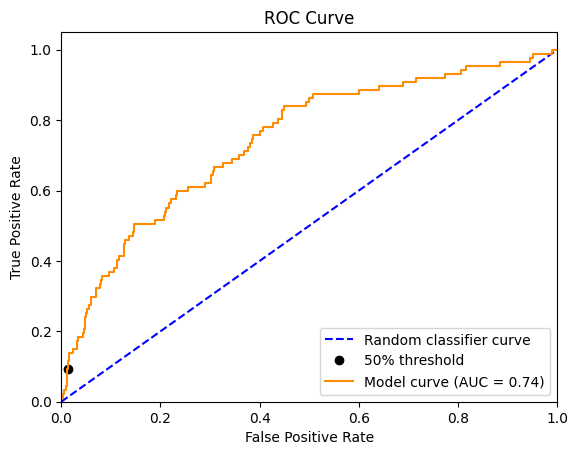

In [14]:
def plot_roc_curve(y_test, y_prob):
    logit_roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) 

    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    #Plotting a random classifier
    plt.plot([0, 1], [0, 1],'b--', label="Random classifier curve")

    idx = np.argmin(np.abs(thresholds-0.5))
    plt.plot(fpr[idx],tpr[idx], "ko", label = "50% threshold")
    
    #Plotting the logistic regression we have built
    plt.plot(fpr, tpr, color='darkorange', label='Model curve (AUC = %0.2f)' % logit_roc_auc)
    
    #Adding labels and etc
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
# Calling the function    
plot_roc_curve(y_test,log_reg.predict_proba(X_test)[:, 1])

The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various **thresholds**. In the context of imbalanced data it requires careful consideration because it is influenced by the prevalence of the majority class. To overcome this problem, it should be complemented with other metrics such as the **precision-recall** curve.

Note that:  
- Sensitivity (TPR) is crucial in scenarios where correctly identifying positive instances (e.g., detecting anomalies or rare events) is of much importance.
- Specificity, on the other hand, reflects the ability to correctly identify negative instances and is vital for maintaining low false positive rates.


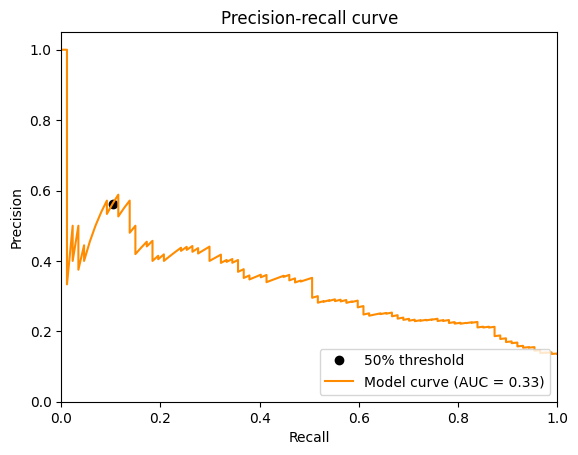

In [15]:
def plot_precision_recall_curve(y_test, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob) 
    auc_score = auc(recall, precision)

    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    idx = np.argmin(np.abs(thresholds-0.5))
    plt.plot(recall[idx],precision[idx], "ko", label = "50% threshold")
    
    #Plotting the logistic regression we have built
    plt.plot(recall, precision, color='darkorange', label='Model curve (AUC = %0.2f)' % auc_score)
    
    #Adding labels and etc
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

    
# Call the function    
plot_precision_recall_curve(y_test,log_reg.predict_proba(X_test)[:, 1])

The precision-recall curve is not influenced by the prevalence of the majority class.

## Brief Discussion on Methods to Address Class Imbalance

1. **LogisticRegression with balanced weights**: 
   - Automatically adjust the weights inversely proportional to class frequencies in the input data. 
   - The algorithm adjusts the optimization process by applying these class weights to the loss function. As a result, the model learns to minimize the weighted sum of errors, penalizing misclassifications in the minority class more heavily than in the majority class.

2. **LogisticRegression with custom class weights**:
   - Instead of using the default balancing mechanism, it allows to specify custom class weights.
   - More control over how the model handles class imbalance.


3. **Bootstrapping**:
   - Resampling to balance the dataset.
   - Create a new dataset by bootstrapping from the minority class.
     
4. **Downsampling**:
    - Resampling to balance the dataset.
    - Create a new dataset by downsampling from the majority class.

6. **SMOTE (Synthetic Minority Over-sampling Technique)**:
   - Oversampling technique that generates synthetic samples for the minority class.
   - Benefit: by generating synthetic samples rather than simply replicating existing ones, SMOTE can increase the diversity of the minority class, potentially leading to better generalization and reduced overfitting.
   - Really elegant and beautiful: a bit of topology comes into play, also in more advanced SMOTE settings. 


### **1. LogisticRegression with balanced weights**

              precision    recall  f1-score   support

         0.0       0.93      0.71      0.81       554
         1.0       0.27      0.68      0.39        87

    accuracy                           0.71       641
   macro avg       0.60      0.70      0.60       641
weighted avg       0.84      0.71      0.75       641



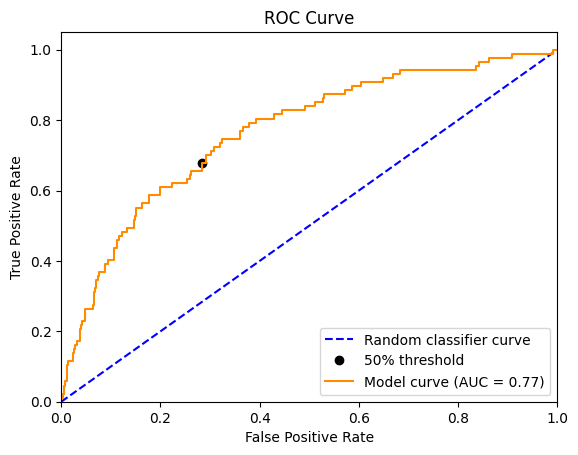

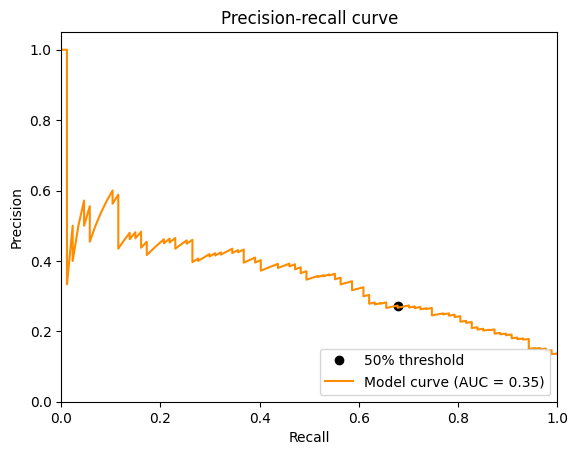

In [16]:
log_reg_balanced = LogisticRegression(class_weight="balanced")
log_reg_balanced.fit(X_train, y_train)

y_pred = log_reg_balanced.predict(X_test)
print(classification_report(y_test, y_pred))

plot_roc_curve(y_test,log_reg_balanced.predict_proba(X_test)[:, 1])

plot_precision_recall_curve(y_test,log_reg_balanced.predict_proba(X_test)[:, 1])

### **2. LogisticRegression with custom class weights**

              precision    recall  f1-score   support

         0.0       0.94      0.64      0.77       554
         1.0       0.25      0.76      0.38        87

    accuracy                           0.66       641
   macro avg       0.60      0.70      0.57       641
weighted avg       0.85      0.66      0.71       641



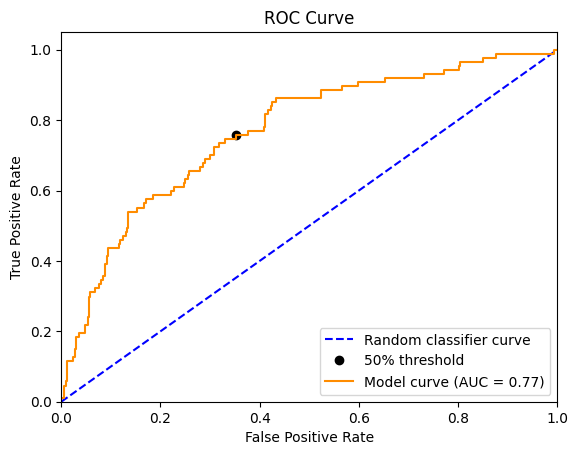

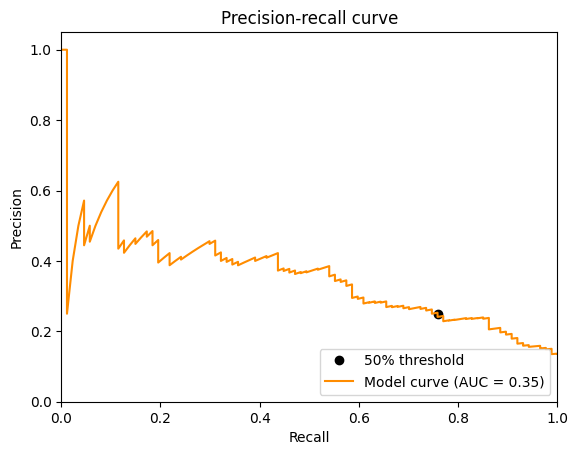

In [17]:
log_reg_balanced = LogisticRegression(class_weight={0:10, 1:90})
log_reg_balanced.fit(X_train, y_train)

y_pred = log_reg_balanced.predict(X_test)
print(classification_report(y_test, y_pred))

plot_roc_curve(y_test,log_reg_balanced.predict_proba(X_test)[:, 1])

plot_precision_recall_curve(y_test,log_reg_balanced.predict_proba(X_test)[:, 1])

### **3. Bootstrapping**

              precision    recall  f1-score   support

         0.0       0.94      0.71      0.80       554
         1.0       0.27      0.69      0.39        87

    accuracy                           0.70       641
   macro avg       0.60      0.70      0.60       641
weighted avg       0.84      0.70      0.75       641



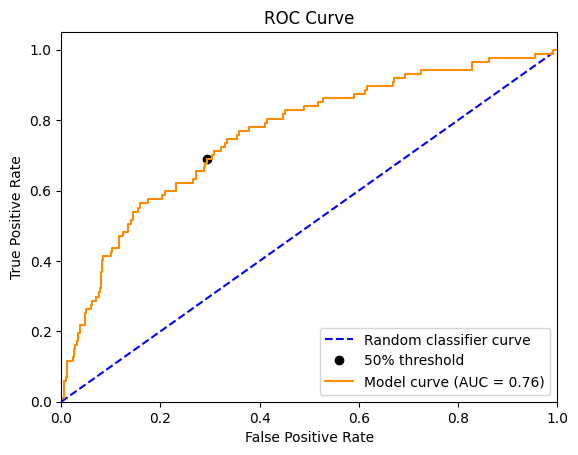

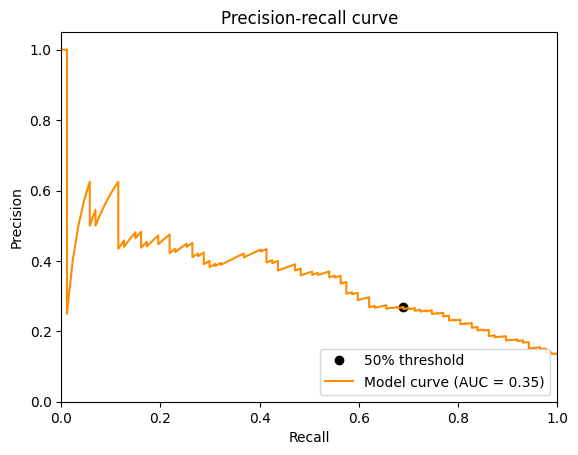

In [18]:
df2 = pd.concat([y_train, X_train], axis=1)

class0 = df2[df2["churn"]==0]
class1 = df2[df2["churn"]==1]

class1_resampled = resample(class1,replace=True, n_samples=len(class0))

df_resampled = pd.concat([class0, class1_resampled])

X_train_resampled = df_resampled[df_resampled.columns.difference(["churn"])]
y_train_resampled = df_resampled["churn"]

log_reg_boots = LogisticRegression()
log_reg_boots.fit(X_train_resampled, y_train_resampled)

y_pred = log_reg_boots.predict(X_test)
print(classification_report(y_test, y_pred))

plot_roc_curve(y_test,log_reg_boots.predict_proba(X_test)[:, 1])

plot_precision_recall_curve(y_test,log_reg_boots.predict_proba(X_test)[:, 1])

### **4. Downsampling**

              precision    recall  f1-score   support

         0.0       0.93      0.74      0.83       554
         1.0       0.28      0.64      0.39        87

    accuracy                           0.73       641
   macro avg       0.61      0.69      0.61       641
weighted avg       0.84      0.73      0.77       641



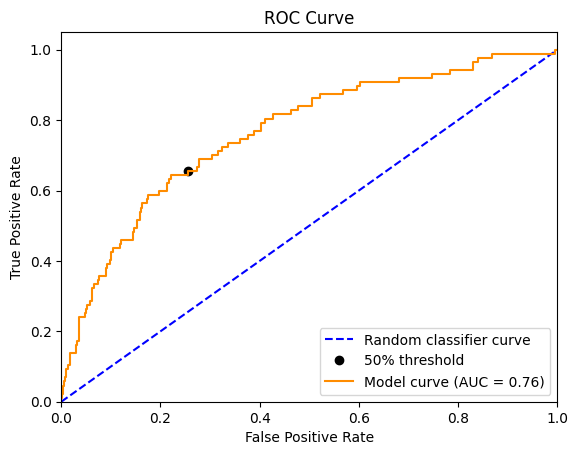

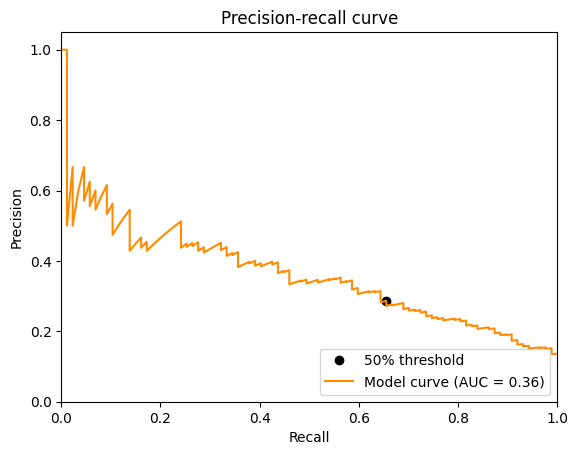

In [19]:
df2 = pd.concat([y_train, X_train], axis=1)

class0 = df2[df2["churn"]==0]
class1 = df2[df2["churn"]==1]

class0_resampled = resample(class0, replace=False, n_samples = len(class1)) # set replacement to false as we do not miss data, we downsample

df_resampled = pd.concat([class0_resampled, class1])

X_train_resampled = df_resampled[df_resampled.columns.difference(["churn"])]
y_train_resampled = df_resampled["churn"]

log_reg_downsampling = LogisticRegression()
log_reg_downsampling.fit(X_train_resampled, y_train_resampled)

y_pred = log_reg_downsampling.predict(X_test)
print(classification_report(y_test, y_pred))

plot_roc_curve(y_test,log_reg_downsampling.predict_proba(X_test)[:, 1])

plot_precision_recall_curve(y_test,log_reg_downsampling.predict_proba(X_test)[:, 1])

### **5. SMOTE**

              precision    recall  f1-score   support

         0.0       0.94      0.69      0.79       554
         1.0       0.27      0.72      0.39        87

    accuracy                           0.69       641
   macro avg       0.60      0.71      0.59       641
weighted avg       0.85      0.69      0.74       641



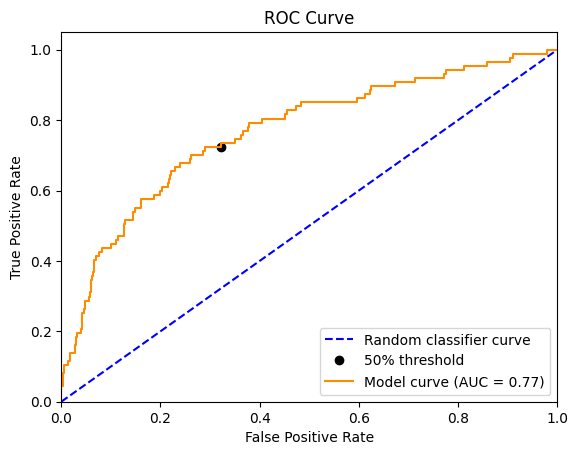

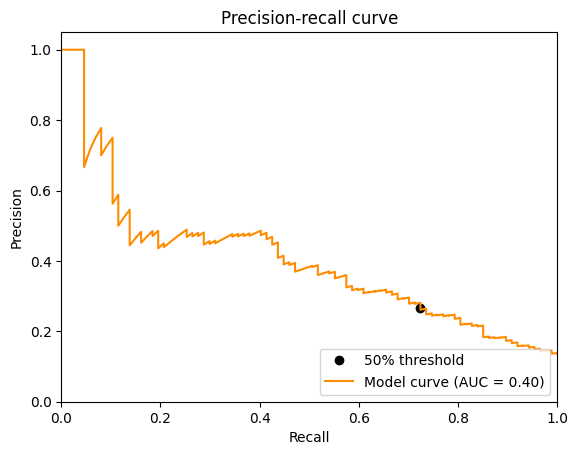

In [20]:
sm = SMOTE(random_state=0, sampling_strategy=1.0)

X_train, y_train = sm.fit_resample(X_train, y_train)

log_reg_smote = LogisticRegression()
log_reg_smote.fit(X_train, y_train)

y_pred = log_reg_smote.predict(X_test)
print(classification_report(y_test, y_pred))

plot_roc_curve(y_test,log_reg_smote.predict_proba(X_test)[:, 1])

plot_precision_recall_curve(y_test,log_reg_smote.predict_proba(X_test)[:, 1])

## Conclusion

We have observed that traditional evaluation metrics such as accuracy, ROC curve and AUC fail to adequately capture the performance differences between models when dealing with imbalanced data. However, precision-recall curves offer a more appropriate evaluation, helping to identify each model's ability to correctly identify churn instances while minimizing false positives.

### Which model and threshold to choose?

It will always depend on the underlying business objective:
- High Precision, Moderate Recall: if the cost of incorrectly identifying customers as churners is high, and e.g. resources for retention efforts are limited.
- High Recall, Moderate Precision: if the cost of missing churn cases is significant and capturing them all is the focus of the problem.

In [24]:
# Model calibration example for the smote model

precision, recall, thresholds = precision_recall_curve(y_test, log_reg_smote.predict_proba(X_test)[:, 1])

desired_recall = 0.7

thresh = thresholds[np.argmin(np.abs(recall-desired_recall))]

y_pred = (log_reg_smote.predict_proba(X_test)[:,1] > thresh).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.81       554
         1.0       0.28      0.70      0.40        87

    accuracy                           0.71       641
   macro avg       0.61      0.71      0.61       641
weighted avg       0.85      0.71      0.76       641

